<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/RNNRegression_GRU_20Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
# Load data

data = pd.read_csv('https://raw.githubusercontent.com/indhu68/Intro_to_DL_Project/main/Kasungu_Telemetry_Pts_Oct23.csv', parse_dates=['Time.Stamp'])
data = data[["Index","Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)

In [3]:
# Preprocessing
data['Time_diff'] = data['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data['Latitude'].diff().fillna(0)
data['Lon_diff'] = data['Longitude'].diff().fillna(0)
data['Speed'] = np.sqrt(data['Lat_diff']**2 + data['Lon_diff']**2) / (data['Time_diff'] + 1e-5)
data.fillna(method='ffill', inplace=True)

In [4]:
# Normalize features
scaler = MinMaxScaler()
numeric_columns = ['Latitude', 'Longitude']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [5]:
def create_sequences(data, n_input=200, n_output=20):
    X, y = [], []
    for i in range(n_input, len(data) - n_output + 1):
        X.append(data.iloc[i-n_input:i][numeric_columns].values)
        y.append(data.iloc[i:i+n_output][['Latitude', 'Longitude']].values.flatten())
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = create_sequences(data)


In [6]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# PyTorch datasets and loaders
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
# Define the LSTM model with attention
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs):
        # Apply a linear layer and tanh activation (energy = W*h + b)
        energy = torch.tanh(self.attn(encoder_outputs))
        attention = self.v(energy)  # v is another linear layer to reduce dimensionality to 1 (scores)
        attention = attention.squeeze(2)
        return F.softmax(attention, dim=1)

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers = 3, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_dim)  # Ensure output_dim matches the flattened target size

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch, seq_len, hidden_size)
        attn_weights = self.attention(lstm_out)  # attention weights for each timestep
        context_vector = torch.bmm(attn_weights.unsqueeze(1), lstm_out).squeeze(1)  # weighted sum of lstm outputs
        output = self.fc(context_vector)  # Final output layer
        return output  # No need to reshape as the output should already be in the correct flat format


# Example usage
model = LSTMAttentionModel(input_dim=2, hidden_size=128, output_dim=40).to('cuda')

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()


Epoch 1: Train Loss: 0.0033, Validation Loss: 0.0004
Saving model (epoch 1, loss improved from inf to 0.0004)
Epoch 2: Train Loss: 0.0011, Validation Loss: 0.0031
Epoch 3: Train Loss: 0.0009, Validation Loss: 0.0006
Epoch 4: Train Loss: 0.0011, Validation Loss: 0.0004
Saving model (epoch 4, loss improved from 0.0004 to 0.0004)
Epoch 5: Train Loss: 0.0005, Validation Loss: 0.0005
Epoch 6: Train Loss: 0.0005, Validation Loss: 0.0006
Epoch 7: Train Loss: 0.0005, Validation Loss: 0.0004
Saving model (epoch 7, loss improved from 0.0004 to 0.0004)
Epoch 8: Train Loss: 0.0005, Validation Loss: 0.0004
Epoch 9: Train Loss: 0.0004, Validation Loss: 0.0005
Epoch 10: Train Loss: 0.0004, Validation Loss: 0.0004
Saving model (epoch 10, loss improved from 0.0004 to 0.0004)
Epoch 11: Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 12: Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 13: Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 14: Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 15: Train

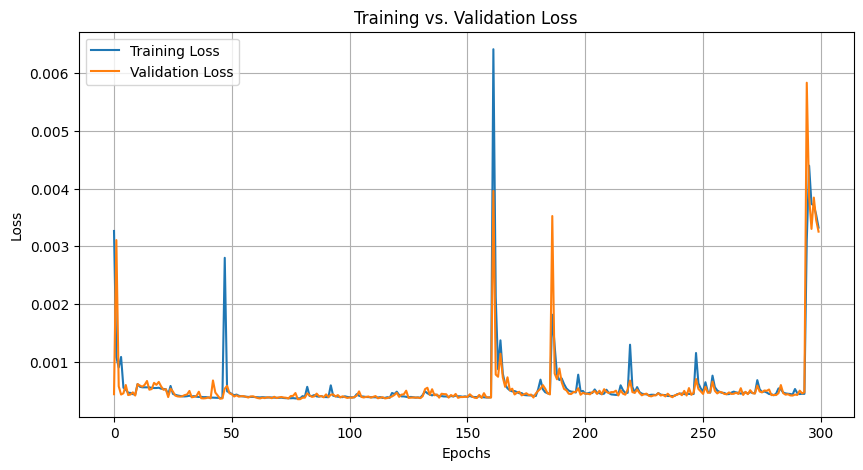

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, val_loader, num_epochs, device):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    best_val_loss = float('inf')

    # Lists to store loss per epoch for plotting
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Save the model if the validation loss has improved
        if avg_val_loss < best_val_loss:
            print(f'Saving model (epoch {epoch+1}, loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f})')
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = avg_val_loss

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model initialization and training
train_and_validate(model, train_loader, test_loader, num_epochs=300, device=device)



In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_model(model, test_loader, device, scaler):
    model.load_state_dict(torch.load('best_model.pth'))
    model.to(device)
    model.eval()

    all_past_data = []
    all_predictions = []
    all_actuals = []
    rmses = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predictions = predictions.view(-1, 10, 2).cpu().numpy()
            actuals = y_batch.view(-1, 10, 2).cpu().numpy()
            past_data = X_batch[:, -100:, :2].view(-1, 100, 2).cpu().numpy()  # Assuming the last 100 points are relevant

            # Inverse transform to original scale
            predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).reshape(-1, 10, 2)
            actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).reshape(-1, 10, 2)
            past_data = scaler.inverse_transform(past_data.reshape(-1, 2)).reshape(-1, 100, 2)

            all_past_data.append(past_data)
            all_predictions.append(predictions)
            all_actuals.append(actuals)

            # Calculate RMSE for this batch and append
            batch_rmse = np.sqrt(mean_squared_error(predictions.reshape(-1, 2), actuals.reshape(-1, 2)))
            rmses.append(batch_rmse)

    average_rmse = np.mean(rmses)
    return all_past_data, all_actuals, all_predictions, rmses, average_rmse

# Example usage
all_past_data, all_actuals, all_predictions, rmses, average_rmse = evaluate_model(model, test_loader, device='cuda', scaler=scaler)
print("Average RMSE:", average_rmse)


Average RMSE: 0.022876985


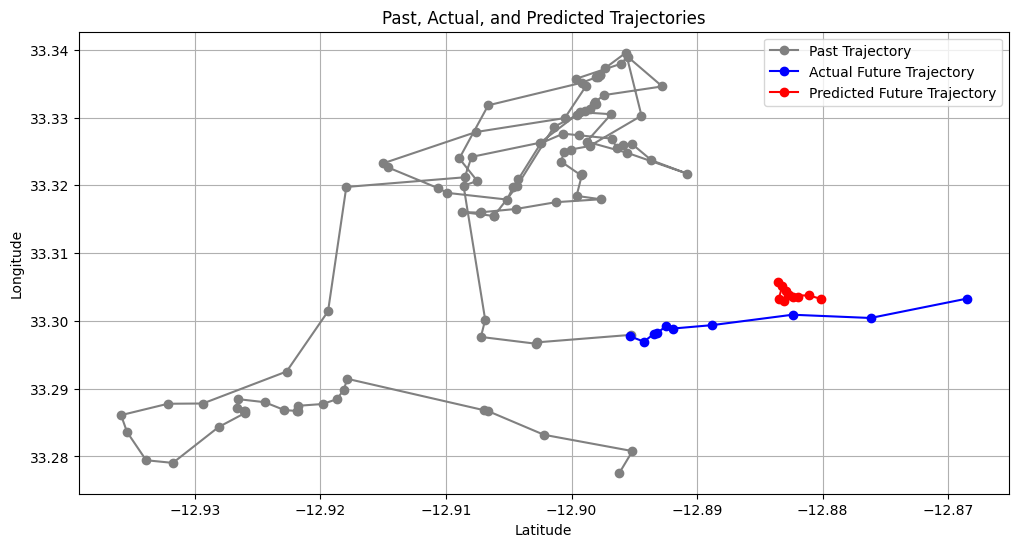

In [11]:
def plot_trajectories(past_data, actuals, predictions, index=0):
    plt.figure(figsize=(12, 6))
    # Plot the past trajectory
    plt.plot(past_data[index][0][:, 0], past_data[index][0][:, 1], 'gray', label='Past Trajectory', marker='o')
    # Plot the actual future trajectory
    plt.plot(actuals[index][0][:, 0], actuals[index][0][:, 1], 'bo-', label='Actual Future Trajectory')
    # Plot the predicted future trajectory
    plt.plot(predictions[index][0][:, 0], predictions[index][0][:, 1], 'ro-', label='Predicted Future Trajectory')

    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Past, Actual, and Predicted Trajectories')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_trajectories(all_past_data, all_actuals, all_predictions, index=0)


In [ ]:
!

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


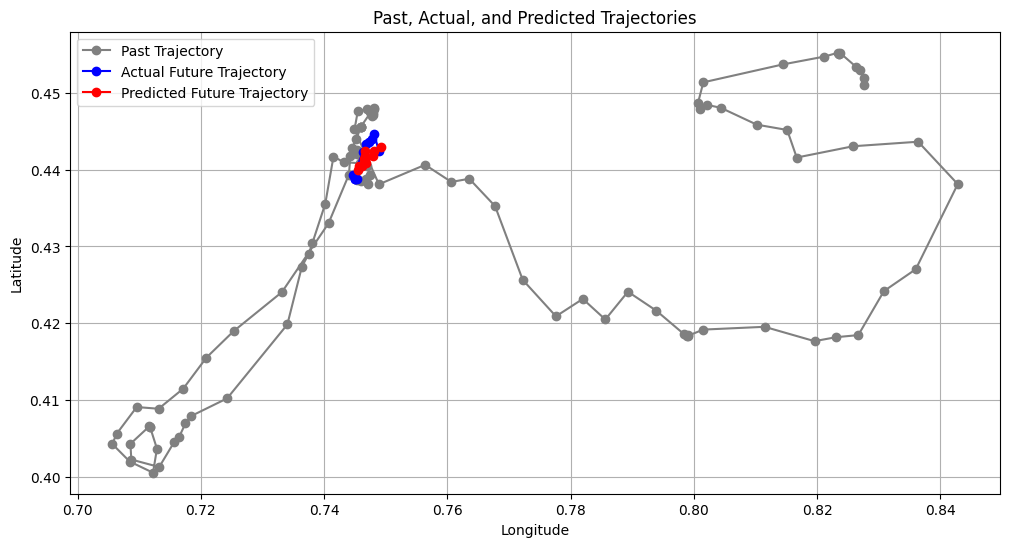

In [ ]:
import matplotlib.pyplot as plt

def plot_trajectories(past_data, actuals, predictions, index=0):
    plt.figure(figsize=(12, 6))

    # Assuming the first index is the sample index and the next two indices are latitude and longitude
    latitude_index = 0  # Adjust if necessary
    longitude_index = 1  # Adjust if necessary

    # Extract the correct two-dimensional slice for plotting
    past_trajectory = past_data[index][0]
    actual_trajectory = actuals[index][0]
    predicted_trajectory = predictions[index][0]

    # Plot the past trajectory
    plt.plot(past_trajectory[:, longitude_index], past_trajectory[:, latitude_index], 'gray', label='Past Trajectory', marker='o')
    # Plot the actual future trajectory
    plt.plot(actual_trajectory[:, longitude_index], actual_trajectory[:, latitude_index], 'bo-', label='Actual Future Trajectory')
    # Plot the predicted future trajectory
    plt.plot(predicted_trajectory[:, longitude_index], predicted_trajectory[:, latitude_index], 'ro-', label='Predicted Future Trajectory')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Past, Actual, and Predicted Trajectories')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage assuming all_past_data, all_actuals, all_predictions have been defined and loaded correctly
plot_trajectories(all_past_data, all_actuals, all_predictions, index=0)


In [ ]:
# DataLoader setup
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train and validate the model
train_and_validate(model, train_loader, val_loader)


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, save_path='model.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()




In [ ]:
# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)


# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# Load Model Function
def load_model(model, load_path='model.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    fig, ax = plt.subplots(figsize=(12, 6))  # Prepare a single plot for clarity

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # De-normalize data to original scale for plotting
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]

            # Rescale the outputs
            actuals = (actuals * range_lat_lon) + min_lat_lon
            predicteds = (predicteds * range_lat_lon) + min_lat_lon

            # Plot each sequence in the batch
            for actual, predicted in zip(actuals, predicteds):
                observed_seq = X_batch[:, :, :2].cpu().numpy() * range_lat_lon + min_lat_lon
                observed_seq = observed_seq.reshape(-1, 2)  # Reshape if necessary

                # Plot observed, actual, and predicted trajectories
                ax.plot(observed_seq[:, 0], observed_seq[:, 1], 'k.-', label='Observed' if _ == 0 else "")
                ax.plot(actual[:, 0], actual[:, 1], 'bo-', label='Actual' if _ == 0 else "")
                ax.plot(predicted[:, 0], predicted[:, 1], 'rx--', label='Predicted' if _ == 0 else "")

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_title('Comparison of Observed, Actual, and Predicted Trajectories')
    ax.legend()
    plt.show()

    avg_loss = total_loss / len(dataloader)
    print(f'Average Loss: {avg_loss}')


# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)


NameError: name 'load_model' is not defined

In [ ]:
import folium

def evaluate_with_folium(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    map = None

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range for each point in the prediction
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]

            actuals *= range_lat_lon
            actuals += min_lat_lon
            predicteds *= range_lat_lon
            predicteds += min_lat_lon

            # Initialize the map with the first actual point
            if map is None:
                map = folium.Map(location=[actuals[0, 0, 0], actuals[0, 0, 1]], zoom_start=12)

            # Add actual and predicted paths to the map
            folium.PolyLine(actuals[0, :, :2].tolist(), color="blue", weight=2.5, opacity=1).add_to(map)
            folium.PolyLine(predicteds[0, :, :2].tolist(), color="red", weight=2.5, opacity=1).add_to(map)

    avg_loss = total_loss / len(dataloader)
    print(f'Average Loss: {avg_loss}')
    return map

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
map = evaluate_with_folium(model, test_loader, criterion, scaler)
map.save('map.html')
map


Average Loss: 0.0004864865360247188


In [ ]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        energy = torch.tanh(self.attn(encoder_outputs))
        attention_scores = self.v(energy).squeeze(2)
        return torch.softmax(attention_scores, dim=1)

class RNNModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(5, 32)
        self.rnn = nn.RNN(input_size=32, hidden_size=hidden_size, num_layers=3, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.fc1(x)
        rnn_out, _ = self.rnn(x)
        attention_weights = self.attention(rnn_out)
        context = torch.bmm(attention_weights.unsqueeze(1), rnn_out).squeeze(1)
        output = self.fc(context)
        return output

rnn_model = RNNModel(hidden_size=128).to('cuda')
criterion_rnn = nn.MSELoss()
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=0.001)


Epoch 1: Training Loss: 8.834550580238731e-06, Validation Loss: 8.483155373194354e-06
Epoch 2: Training Loss: 8.819756185828677e-06, Validation Loss: 8.657659539037842e-06
Epoch 3: Training Loss: 8.821037677115462e-06, Validation Loss: 1.955632571560777e-05
Epoch 4: Training Loss: 8.859682135777676e-06, Validation Loss: 8.782809555093614e-06
Epoch 5: Training Loss: 8.842236940212365e-06, Validation Loss: 9.303414642721905e-06
Epoch 6: Training Loss: 8.791502848006135e-06, Validation Loss: 9.575989938149318e-06
Epoch 7: Training Loss: 8.751677820952737e-06, Validation Loss: 8.585882734795699e-06
Epoch 8: Training Loss: 8.805398045789739e-06, Validation Loss: 8.486823340062862e-06
Epoch 9: Training Loss: 8.781899915328741e-06, Validation Loss: 8.894202363957517e-06
Epoch 10: Training Loss: 8.805186119654763e-06, Validation Loss: 8.385579834073742e-06
Epoch 11: Training Loss: 8.77891608260621e-06, Validation Loss: 8.148977755992143e-06
Epoch 12: Training Loss: 8.753643460059689e-06, Valid

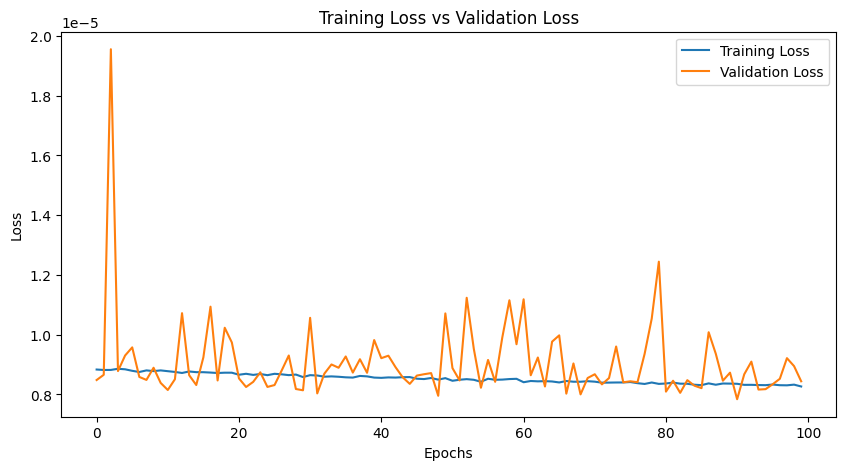

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, save_path='model_SimpleRNN.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)
# Load Model Function
def load_model(model, load_path='model_SimpleRNN.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model


Actual: [-12.90168   33.304497], Predicted: [-12.9023905  33.297398 ]
Actual: [-13.029982  33.29644 ], Predicted: [-13.028299  33.29928 ]
Actual: [-13.118703  33.13329 ], Predicted: [-13.116478  33.133533]
Actual: [-12.85585   33.264343], Predicted: [-12.857739  33.264175]
Actual: [-12.854888  33.10686 ], Predicted: [-12.854308  33.106304]
Actual: [-12.880608  33.234737], Predicted: [-12.874687  33.224026]
Actual: [-12.811612  33.200798], Predicted: [-12.814389  33.2026  ]
Actual: [-12.867573  33.26665 ], Predicted: [-12.87026  33.26307]
Actual: [-12.928633  33.296913], Predicted: [-12.928369  33.29556 ]
Actual: [-13.184363  33.171646], Predicted: [-13.192658  33.16815 ]

Average Loss: 8.439904611937312e-06
 RMSE: 0.059869248420000076


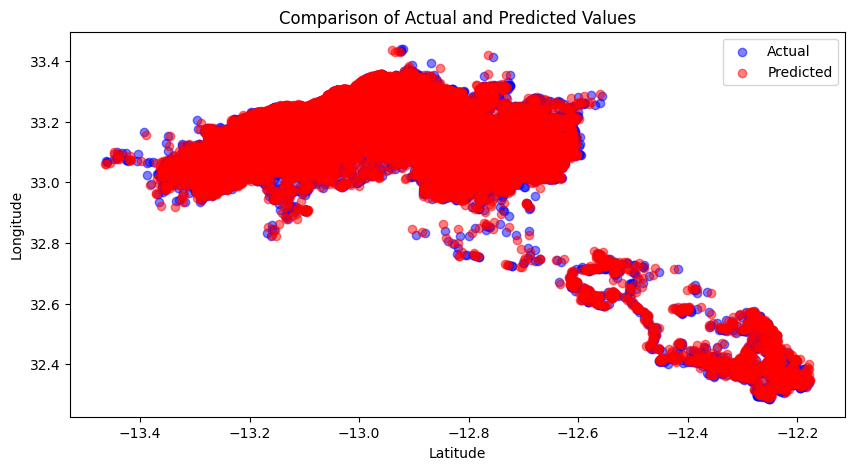

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    errors = []
    actuals_list = []
    predicteds_list = []
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

                # Calculate RMSE for latitude and longitude combined
                error = np.sqrt(np.sum((actual[:2] - predicted[:2])**2))
                errors.append(error)

    avg_loss = total_loss / len(dataloader)
    avg_rmse = np.sqrt(np.mean(errors))

    print(f'\nAverage Loss: {avg_loss}')
    print(f' RMSE: {avg_rmse}')

    # Plotting Actual vs Predicted
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)


In [ ]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        energy = torch.tanh(self.attn(encoder_outputs))
        attention_scores = self.v(energy).squeeze(2)
        return torch.softmax(attention_scores, dim=1)

class GRUModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(5, 32)
        self.gru = nn.GRU(input_size=32, hidden_size=hidden_size, num_layers=3, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.fc1(x)
        gru_out, _ = self.gru(x)
        attention_weights = self.attention(gru_out)
        context = torch.bmm(attention_weights.unsqueeze(1), gru_out).squeeze(1)
        output = self.fc(context)
        return output

gru_model = GRUModel(hidden_size=128).to('cuda')
criterion_gru = nn.MSELoss()
optimizer_gru = torch.optim.Adam(gru_model.parameters(), lr=0.001)


Epoch 1: Training Loss: 8.31380908206615e-06, Validation Loss: 8.186588514369532e-06
Epoch 2: Training Loss: 8.28720237713395e-06, Validation Loss: 8.617323648464805e-06
Epoch 3: Training Loss: 8.30976925721753e-06, Validation Loss: 8.392316874097523e-06
Epoch 4: Training Loss: 8.288126049560474e-06, Validation Loss: 8.230322147410531e-06
Epoch 5: Training Loss: 8.261919561863017e-06, Validation Loss: 8.299394605248013e-06
Epoch 6: Training Loss: 8.253674380140209e-06, Validation Loss: 8.713485852194062e-06
Epoch 7: Training Loss: 8.275392450164295e-06, Validation Loss: 8.393569719195217e-06
Epoch 8: Training Loss: 8.22163025847356e-06, Validation Loss: 7.955822401084286e-06
Epoch 9: Training Loss: 8.251350608495171e-06, Validation Loss: 9.722835649240463e-06
Epoch 10: Training Loss: 8.205673990424266e-06, Validation Loss: 8.077234304068029e-06
Epoch 11: Training Loss: 8.234468259245338e-06, Validation Loss: 8.386133272996948e-06
Epoch 12: Training Loss: 8.24606636438597e-06, Validatio

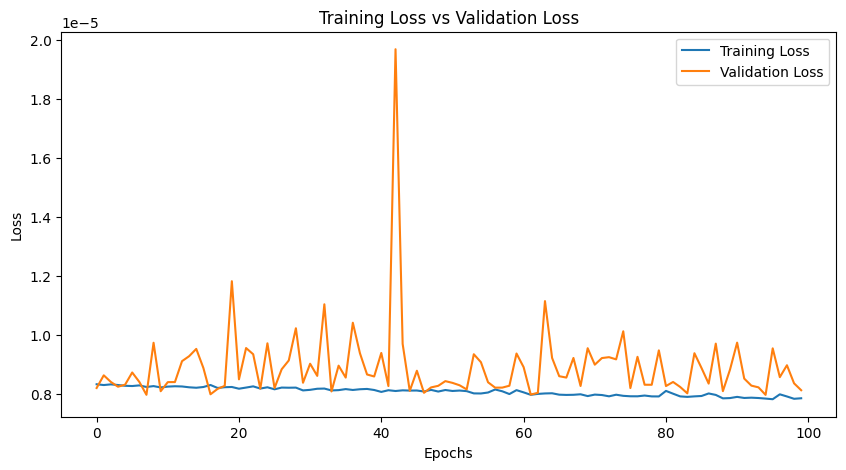

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, save_path='model_GRU.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)
# Load Model Function
def load_model(model, load_path='model_GRU.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model


Actual: [-12.751147  33.07825 ], Predicted: [-12.74804   33.079426]
Actual: [-12.925635  33.31286 ], Predicted: [-12.92655  33.31348]
Actual: [-12.832962  33.180943], Predicted: [-12.835041  33.19361 ]
Actual: [-12.741708  33.169395], Predicted: [-12.741978  33.16896 ]
Actual: [-13.044553  33.090206], Predicted: [-13.043968  33.089825]
Actual: [-12.866535  33.28155 ], Predicted: [-12.867996  33.277   ]
Actual: [-12.650365  33.12508 ], Predicted: [-12.645014  33.12886 ]
Actual: [-12.878525  33.220177], Predicted: [-12.877537  33.22369 ]
Actual: [-13.07102   33.115757], Predicted: [-13.066873  33.123222]
Actual: [-12.841283  33.19427 ], Predicted: [-12.838464  33.197063]

Average Loss: 8.116573676226635e-06
 RMSE: 0.057868484407663345


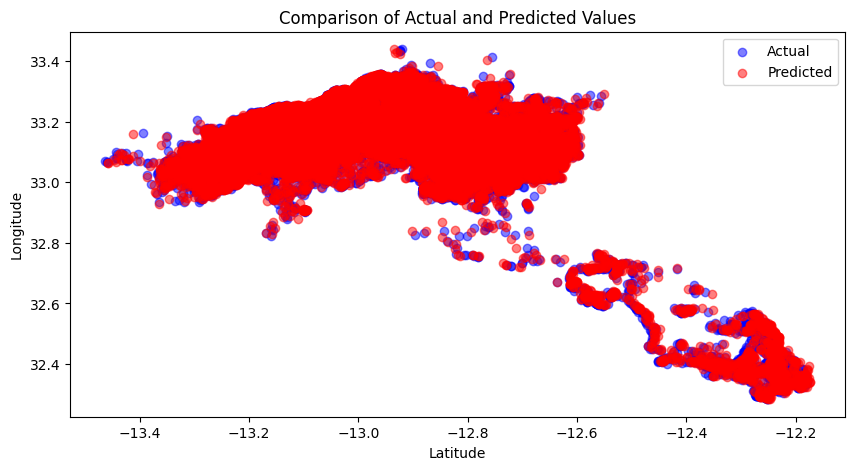

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    errors = []
    actuals_list = []
    predicteds_list = []
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

                # Calculate RMSE for latitude and longitude combined
                error = np.sqrt(np.sum((actual[:2] - predicted[:2])**2))
                errors.append(error)

    avg_loss = total_loss / len(dataloader)
    avg_rmse = np.sqrt(np.mean(errors))

    print(f'\nAverage Loss: {avg_loss}')
    print(f' RMSE: {avg_rmse}')

    # Plotting Actual vs Predicted
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)
